In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
from mpl_toolkits import mplot3d
from scipy.stats import spearmanr
import collections
import feather
from scipy import stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import regionmask
import xesmf

import sys
sys.path.append('../')
import utils
import plotting


#### Approach

1. sum each row to get the annual total per generator
2. sum the rows by state in which the generator is located
3. import egrids data
4. subtract the model output by state from the state annual emissions from egrid

# Import Data

In [2]:
models = ['normal_model','nonuc_model','no_coal','nox_lim']
pollutants = ['NO','NO2','SO2','CO2','CH4']

regionname_grouped_ds = xr.open_zarr(f'./final_data/regionname_grouped_emissions_ds.zarr')
fueltype_grouped_ds = xr.open_zarr(f'./final_data/fueltype_grouped_emissions_ds.zarr')
gmodel_egrid_ds = xr.open_zarr(f'./final_data/gmodel_egrid_emissions_ds.zarr')
oris_nonuc_ds = xr.open_zarr(f'./final_data/oris_nonuc_ds.zarr')

In [3]:
region_season = utils.season_mean(regionname_grouped_ds.rename({'date':'time'}))
fuel_season = utils.season_mean(fueltype_grouped_ds.rename({'date':'time'}))


In [4]:
convert_NO_N = 14.01/30.01
convert_NO2_N = 14.01/46.01
gmodel_egrid_ds['model_annual_NOx_conc'] = (gmodel_egrid_ds['model_annual_NO_conc']*convert_NO_N+
                                               gmodel_egrid_ds['model_annual_NO2_conc']*convert_NO2_N)

In [158]:
#number of plants with emissions factors above the mean being turned on
for poll in ['CO2','NOX','SO2']:
    print(poll)
    for model in ['nonuc_model', 'normal_model', 'nonuc_nocoal_model']:
        threshold = gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].std().values
        
        print(model, ': plants ', gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['ORISCode'].count().values, 'total generation',
             gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['annual_modelgeneration'].sum().values)
        print('percent of generation from dirtiest plants: ', 100*(gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['annual_modelgeneration'].sum().values/
                                                                         gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'].sum().values))
        if poll == 'NOX':
            poll2 = 'NOx'
        else: 
            poll2 = poll
        print(f'percent of {poll} emissions from dirtiest plants: ', 100*(gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)[f'model_annual_{poll2}_conc'].sum().values/
                                                                         gmodel_egrid_ds.sel(model_name = model)[f'model_annual_{poll2}_conc'].sum().values))
        print(f'{poll} emissions from dirtiest plants: ', (gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)[f'model_annual_{poll2}_conc'].sum().values))

CO2
nonuc_model : plants  2 total generation 2516246.4282249594
percent of generation from dirtiest plants:  0.06163686614684046
percent of CO2 emissions from dirtiest plants:  2.7942923196937364
CO2 emissions from dirtiest plants:  70809681516.82516
normal_model : plants  2 total generation 259918.36147872606
percent of generation from dirtiest plants:  0.006367644548933354
percent of CO2 emissions from dirtiest plants:  0.4059315316861807
CO2 emissions from dirtiest plants:  7314066205.803219
nonuc_nocoal_model : plants  27 total generation 7720287.915545878
percent of generation from dirtiest plants:  0.1887074257079519
percent of CO2 emissions from dirtiest plants:  13.111813027344017
CO2 emissions from dirtiest plants:  249174899983.30487
NOX
nonuc_model : plants  1 total generation 17520.0
percent of generation from dirtiest plants:  0.0004291622166968858
percent of NOX emissions from dirtiest plants:  0.15061346199475567
NOX emissions from dirtiest plants:  1145568.0344484546
no

In [155]:
for poll in ['CO2','NOX','SO2']:
    print(poll)
    threshold = gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'].std().values
    print(model, ': plants ', gmodel_egrid_ds.sel(model_name = 'normal_model').where(gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'] >threshold, drop = True)['ORISCode'].count().values)

CO2
nonuc_nocoal_model : plants  29
NOX
nonuc_nocoal_model : plants  16
SO2
nonuc_nocoal_model : plants  19


In [156]:
for poll in ['CO2','NOX','SO2']:
    print(poll)
    for model in ['nonuc_model', 'normal_model', 'nonuc_nocoal_model']:
        threshold = gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].std().values
        print(model, ': plants ', gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['fueltype'].values)

CO2
nonuc_model : plants  ['Coal' 'NaturalGas']
normal_model : plants  ['Coal' 'NaturalGas']
nonuc_nocoal_model : plants  ['Oil' 'Oil' 'NaturalGas' 'Oil' 'NaturalGas' 'Oil' 'Oil' 'NaturalGas'
 'Oil' 'Oil' 'NaturalGas' 'Oil' 'Oil' 'NaturalGas' 'NaturalGas'
 'NaturalGas' 'Oil' 'Oil' 'Oil' 'Oil' 'Oil' 'NaturalGas' 'Oil' 'Oil' 'Oil'
 'Oil' 'NaturalGas']
NOX
nonuc_model : plants  ['Non-Fossil']
normal_model : plants  ['Non-Fossil']
nonuc_nocoal_model : plants  ['Oil' 'Oil' 'Oil' 'NaturalGas' 'NaturalGas' 'Oil' 'NaturalGas' 'Oil'
 'NaturalGas' 'Oil' 'Oil' 'Oil' 'Oil' 'Oil' 'Non-Fossil']
SO2
nonuc_model : plants  ['Coal' 'Coal' 'Coal' 'Coal' 'Coal' 'Coal' 'Coal' 'Non-Fossil']
normal_model : plants  ['Coal' 'Coal' 'Coal' 'Coal' 'Non-Fossil']
nonuc_nocoal_model : plants  ['Oil' 'Oil' 'NaturalGas' 'Oil' 'Oil' 'Oil' 'Oil' 'Oil' 'NaturalGas' 'Oil'
 'NaturalGas' 'Oil' 'Oil' 'NaturalGas' 'Non-Fossil']


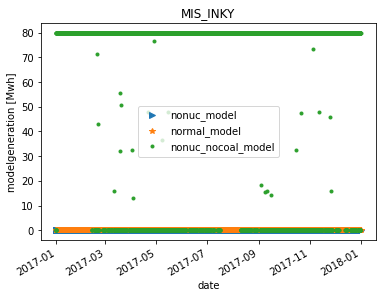

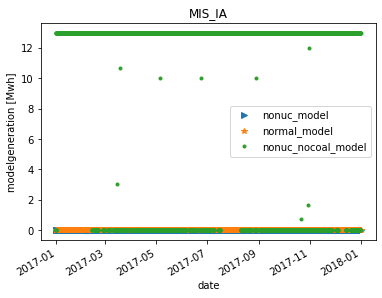

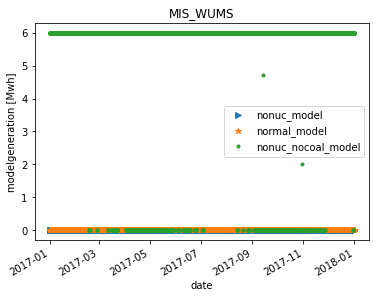

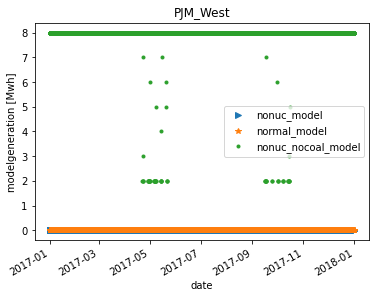

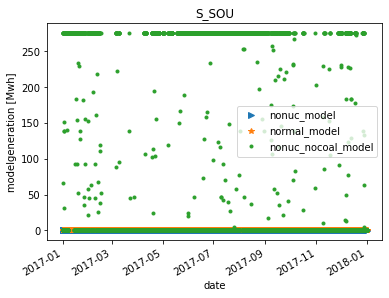

In [32]:
#plot the top pollutors beyond a threshold of NOX emissions
marker_model = {'nonuc_model':'>','normal_model':'*','nonuc_nocoal_model':'.'}
threshold = gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].std().values

for idx, ors in enumerate(gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = 'normal_model')['ORISCode'].values):
    fig, ax = plt.subplots()
    plt.title(ors)
    for model in ['nonuc_model', 'normal_model', 'nonuc_nocoal_model']:
        gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = model, ORISCode = ors)['modelgeneration'].plot(label = model, linestyle = 'None', marker = marker_model[model]);
        plt.legend(loc = 'best')
        plt.title(gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = model, ORISCode = ors)['regionname'].values)

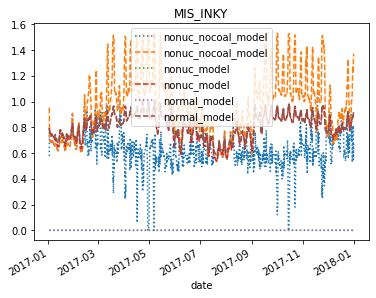

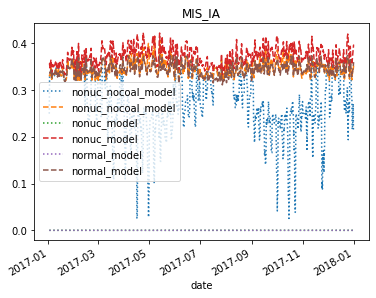

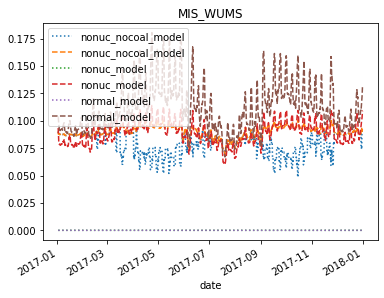

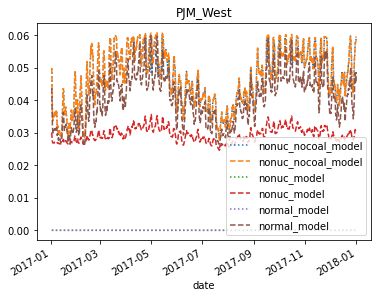

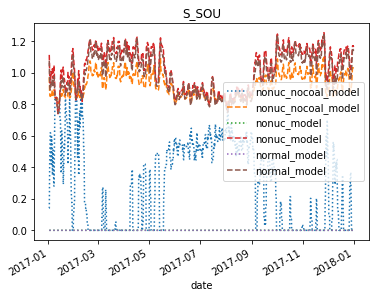

In [105]:
#plot the % of the region's energy produced by highest emitters
for idx, ors in enumerate(gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = model)['ORISCode'].values):
    fig, ax = plt.subplots()
    region = gmodel_egrid_ds.sel(ORISCode = ors, model_name = 'nonuc_model')['regionname'].values
    for model in [ 'nonuc_nocoal_model','nonuc_model', 'normal_model']:
        ((gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = model, ORISCode = ors)['modelgeneration']/
         gmodel_egrid_ds.where( 
                    gmodel_egrid_ds.regionname == gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, 
                                                                           drop = True).sel(model_name = model, 
                                                                                            ORISCode = ors)['regionname'].values).sel(model_name = model)['modelgeneration'].sum(dim = 'ORISCode')).rolling(date = 24).mean()*100).plot(linestyle = 'dotted', label = model)
        
        ((gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = model, ORISCode = ors)['Capacity']/
 gmodel_egrid_ds.where( 
            gmodel_egrid_ds.regionname == gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, 
                                                                   drop = True).sel(model_name = model, 
                                                                                    ORISCode = ors)['regionname'].values).sel(model_name = model)['modelgeneration'].sum(dim = 'ORISCode')).rolling(date = 24).mean()*100).plot(linestyle = 'dashed', label = model)
        
        plt.legend(loc = 'best')
        plt.title(region)

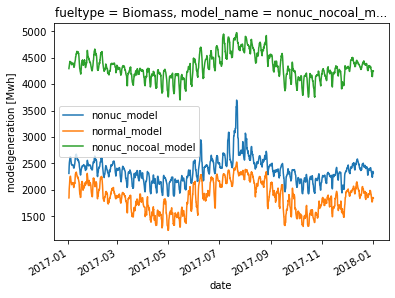

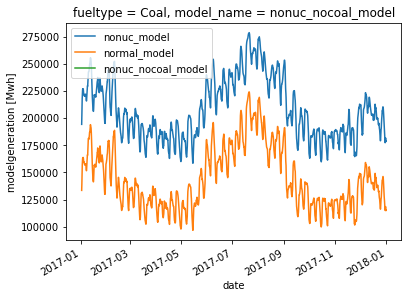

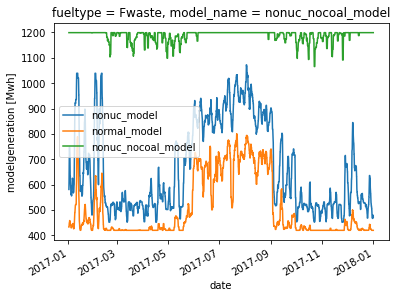

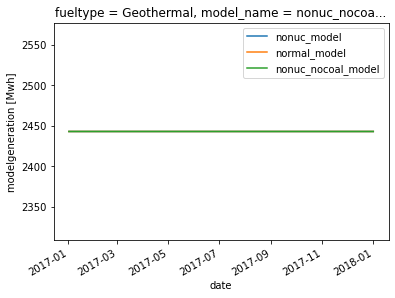

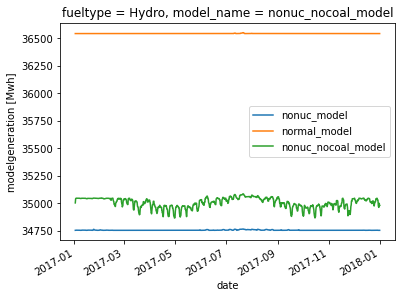

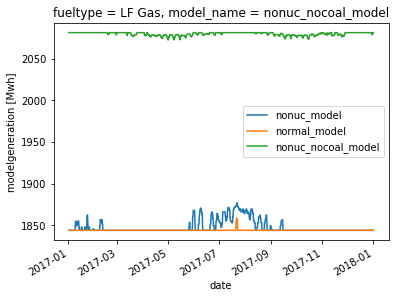

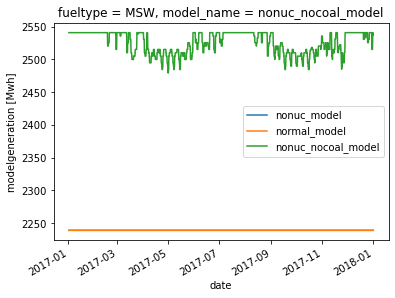

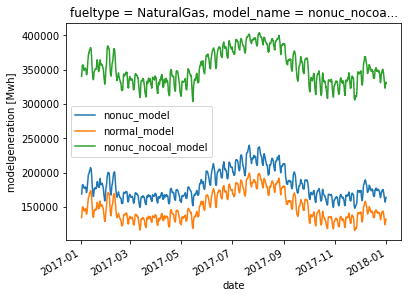

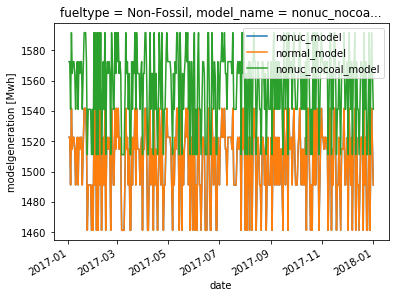

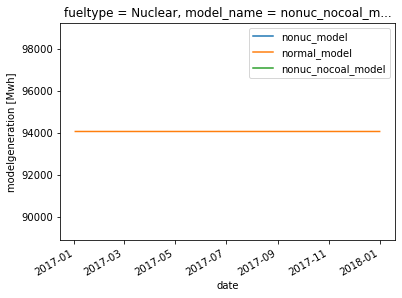

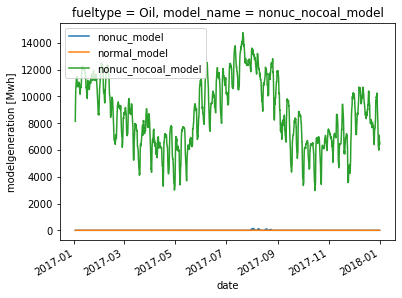

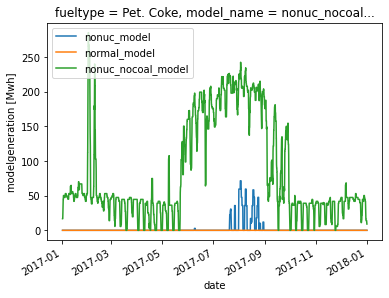

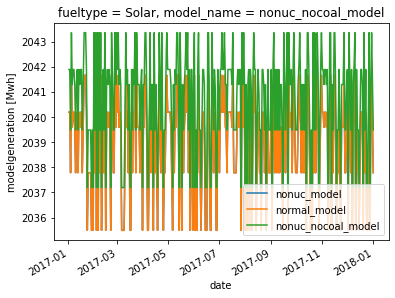

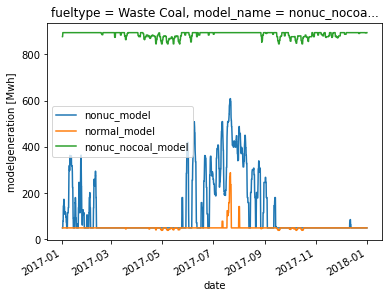

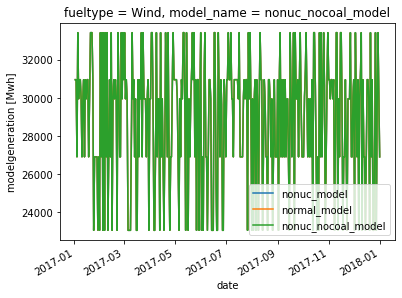

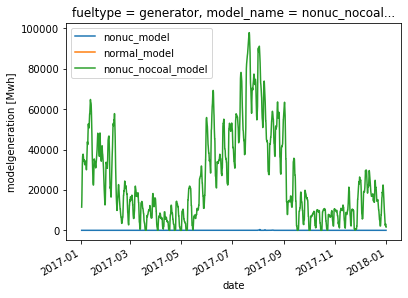

In [52]:
for ft in fueltype_grouped_ds.fueltype.values:
    fig, ax = plt.subplots()
    plt.title(ft)
    for model in ['nonuc_model', 'normal_model', 'nonuc_nocoal_model']:
        fueltype_grouped_ds.sel(fueltype = ft, model_name = model)['modelgeneration'].rolling(date = 24).mean().plot(label = model);
        plt.legend(loc = 'best')

# Regulatory evaluation

In [5]:
convert_NO_N = 14.01/30.01
convert_NO2_N = 14.01/46.01
gmodel_egrid_ds['model_annual_NOx_conc'] = (gmodel_egrid_ds['model_annual_NO_conc']*convert_NO_N+
                                               gmodel_egrid_ds['model_annual_NO2_conc']*convert_NO2_N)

## Simple calculation

In [6]:
limit3_df = pd.read_excel('./final_data/unit-level_allocations_and_underlying_data_for_the_revised_csapr_update_final_rule_with_supplemental.xls', sheet_name = 'Final Merged RCU Allocations')
limit2_df = pd.read_excel('./final_data/unit_level_allocations_and_underlying_data_for_the_csapr_for_the_2008_oz.xls', sheet_name = 'Final Allocations')
limit1_df = pd.read_excel('./final_data/epa-hq-oar-2009-0491-5029.xlsx', sheet_name = 'Complete Allocations')
#https://www.epa.gov/csapr/csapr-allowance-allocations ##revised CSAPR allocations

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [7]:
#rename columns
limit3_df = limit3_df.rename(columns = {'NOx OS Allocation 2024 and Beyond (tons)':'Group 3 2024 NOx OS Allowance (tons)', 'ORIS ID':'ORISCode'})
limit2_df = limit2_df.rename(columns = {'NOx OS Allocation 2018 and Beyond (tons) 1':'Group 2 2018 NOx OS Beyond Allowance (tons)', 'ORIS ID':'ORISCode'})
limit1_df = limit1_df.rename(columns = {'NOx OS Allocation 2020 (tons)':'Group 1 2020 NOx OS Allowance (tons)', 'ORIS ID':'ORISCode'})
#use the latest year-to-date allowance from each of the groups for ozone season
limit_df = limit3_df[['Group 3 2024 NOx OS Allowance (tons)', 'ORISCode','Boiler ID','State']].merge(limit2_df[['Group 2 2018 NOx OS Beyond Allowance (tons)','ORISCode','Boiler ID','State']], 
                                                                                  on = ['ORISCode','Boiler ID','State'], how = 'outer').merge(limit1_df[['Group 1 2020 NOx OS Allowance (tons)','ORISCode','Boiler ID','State']], 
                                                                                  on = ['ORISCode','Boiler ID','State'], how = 'outer')
limit_df['NOx OS Allowance (tons)'] = limit_df['Group 3 2024 NOx OS Allowance (tons)']
limit_df.loc[np.isnan(limit_df['NOx OS Allowance (tons)']), 'NOx OS Allowance (tons)'] = limit_df.loc[np.isnan(limit_df['NOx OS Allowance (tons)']),'Group 2 2018 NOx OS Beyond Allowance (tons)']
limit_df.loc[np.isnan(limit_df['NOx OS Allowance (tons)']), 'NOx OS Allowance (tons)'] = limit_df.loc[np.isnan(limit_df['NOx OS Allowance (tons)']),'Group 1 2020 NOx OS Allowance (tons)']

In [8]:
#summer only
gmodel_egrid_ds['model_summer_NOx_conc'] = ((gmodel_egrid_ds['model_NO2_rate']*3600).sel(date = slice('2017-05-01T00:00:00.000000000',
                                                          '2017-09-01T00:00:00.000000000')).sum(dim = 'date')*convert_NO2_N + 
 (gmodel_egrid_ds['model_NO_rate']*3600).sel(date = slice('2017-05-01T00:00:00.000000000',
                                                          '2017-09-01T00:00:00.000000000')).sum(dim = 'date')*convert_NO_N )

In [9]:
limit_nonuc_df = gmodel_egrid_ds[['model_summer_NOx_conc','model_annual_NOx_conc','annual_modelgeneration']].sel(model_name = 'nonuc_model').to_dataframe().merge(limit_df, on = 'ORISCode')
limit_nonuc_coal_df = gmodel_egrid_ds[['model_summer_NOx_conc','model_annual_NOx_conc','annual_modelgeneration']].sel(model_name = 'nonuc_nocoal_model').to_dataframe().merge(limit_df, on = 'ORISCode')
limit_norm_df = gmodel_egrid_ds[['model_summer_NOx_conc','model_annual_NOx_conc','annual_modelgeneration']].sel(model_name = 'normal_model').to_dataframe().merge(limit_df, on = 'ORISCode')
limit_noxlim_df = gmodel_egrid_ds[['model_summer_NOx_conc','model_annual_NOx_conc','annual_modelgeneration']].sel(model_name = 'nox_lim_model').to_dataframe().merge(limit_df, on = 'ORISCode')


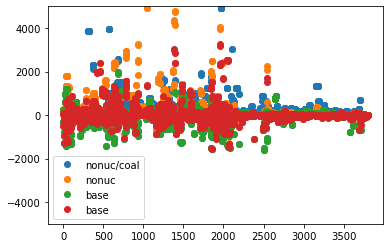

In [10]:
(limit_nonuc_coal_df['model_summer_NOx_conc']/1000-limit_nonuc_coal_df['NOx OS Allowance (tons)']).plot(marker = 'o', linestyle = 'None', label = 'nonuc/coal')
(limit_nonuc_df['model_summer_NOx_conc']/1000-limit_nonuc_df['NOx OS Allowance (tons)']).plot(marker = 'o', linestyle = 'None', label = 'nonuc')
(limit_noxlim_df['model_summer_NOx_conc']/1000-limit_noxlim_df['NOx OS Allowance (tons)']).plot(marker = 'o', linestyle = 'None', label = 'base')
(limit_norm_df['model_summer_NOx_conc']/1000-limit_norm_df['NOx OS Allowance (tons)']).plot(marker = 'o', linestyle = 'None', label = 'base')

plt.ylim(-5000, 5000)
plt.legend()

In [11]:
len(limit_nonuc_coal_df)

3801

In [12]:
((100*(limit_nonuc_coal_df['model_annual_NOx_conc']/1000-
  limit_nonuc_coal_df['NOx OS Allowance (tons)'])/
 limit_nonuc_coal_df['NOx OS Allowance (tons)'])>10).sum()

2556

In [13]:
((limit_nonuc_coal_df['model_summer_NOx_conc']/1000-
  limit_nonuc_coal_df['NOx OS Allowance (tons)']) >0).sum()

2306

In [14]:
((limit_norm_df['model_summer_NOx_conc']/1000-
  limit_norm_df['NOx OS Allowance (tons)']) >0).sum()

1181

In [15]:
((limit_nonuc_df['model_summer_NOx_conc']/1000-
  limit_nonuc_df['NOx OS Allowance (tons)']) >0).sum()

1601

In [16]:
limit_nonuc_df['model_summer_NOx_conc'] /= 1000
limit_norm_df['model_summer_NOx_conc'] /= 1000

In [17]:
limit_nonuc_coal_df['model_summer_NOx_conc'] /= 1000

In [18]:
limit_noxlim_df['model_summer_NOx_conc'] /= 1000

In [19]:
## normal test

In [20]:
state_lim_df = pd.read_excel('final_data/2018_csapr_assurance_provision_0.xlsx', header = 1)

In [21]:
state_lim_df = state_lim_df[:22]

In [23]:
state_total = pd.DataFrame(limit_nonuc_coal_df.groupby(['State']).sum()[['model_annual_NOx_conc','NOx OS Allowance (tons)']])
state_total = state_total.rename(columns = {'model_summer_NOx_conc':'state_total_NOx', 'NOx OS Allowance (tons)': 'NOx OS Allowance State'}).reset_index()


In [24]:
state_total = state_total.merge(state_lim_df, on = 'State', how = 'right')

In [25]:
state_total['model_annual_NOx_conc'] /=1000

In [26]:
state_total

,State,model_annual_NOx_conc,NOx OS Allowance State,CSAPR Budget (tons),CSAPR Assurance Level (tons),2018 Emissions for Compliance,2018 Assurance Level Exceeded?
0,Alabama,9.319455e+04,21110.0,71962.0,84915.16,24470.0,No
1,Georgia,2.154624e+06,8449.0,53738.0,63410.84,25615.0,No
2,Illinois,1.392588e+05,13386.0,47872.0,56488.96,32070.0,No
3,Indiana,3.686227e+04,16483.0,108424.0,127940.32,61515.0,No
4,Iowa,5.586165e+04,11287.0,37498.0,44247.64,24219.0,No
5,Kansas,1.494915e+05,7871.0,31354.0,36997.72,13978.0,No
6,Kentucky,6.203231e+04,21441.0,77238.0,91140.84,47399.0,No
7,Maryland,1.112099e+05,2066.0,16574.0,19557.32,6642.0,No
8,Michigan,9.034514e+04,15344.0,63040.0,74387.20,39280.0,No
9,Minnesota,1.954559e+04,0.0,29572.0,34894.96,17657.0,No


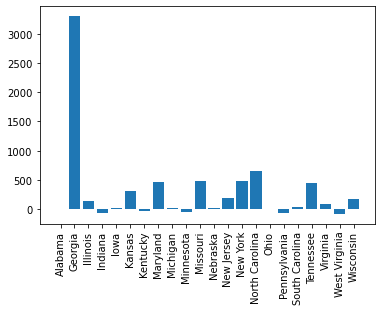

In [29]:
plt.bar(state_total['State'], ((state_total['model_annual_NOx_conc'] - state_total['CSAPR Assurance Level (tons)'])/state_total['CSAPR Assurance Level (tons)'])*100)
plt.xticks(rotation = 90);

In [166]:
limit_nonuc_coal_df['dif_summer'] = (limit_nonuc_coal_df.loc[limit_nonuc_coal_df['State'] == 'Georgia']['model_summer_NOx_conc'] - 
    limit_nonuc_coal_df.loc[limit_nonuc_coal_df['State'] == 'Georgia']['NOx OS Allowance (tons)'])

In [172]:
limit_nonuc_coal_df.loc[limit_nonuc_coal_df['dif_summer'] == limit_nonuc_coal_df['dif_summer'].max()]

,ORISCode,model_summer_NOx_conc,model_annual_NOx_conc,annual_modelgeneration,fueltype,model_name,regionname,Group 3 2024 NOx OS Allowance (tons),Boiler ID,State,Group 2 2018 NOx OS Beyond Allowance (tons),Group 1 2020 NOx OS Allowance (tons),NOx OS Allowance (tons),dif_summer
2053,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1A,Georgia,0.0,0.0,0.0,182618.41431
2054,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1B,Georgia,0.0,0.0,0.0,182618.41431
2055,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1C,Georgia,0.0,0.0,0.0,182618.41431
2056,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1D,Georgia,0.0,0.0,0.0,182618.41431
2057,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1E,Georgia,0.0,0.0,0.0,182618.41431
2058,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1F,Georgia,0.0,0.0,0.0,182618.41431


In [178]:
limit2_df.loc[limit2_df['ORISCode'] == 6258]

,Plant Name,State,ORISCode,Boiler ID,NOx OS Allocation 2017 (tons),Group 2 2018 NOx OS Beyond Allowance (tons)
165,Allen B Wilson Combustion Turbine Plant,Georgia,6258.0,1A,0.0,0.0
166,Allen B Wilson Combustion Turbine Plant,Georgia,6258.0,1B,0.0,0.0
167,Allen B Wilson Combustion Turbine Plant,Georgia,6258.0,1C,0.0,0.0
168,Allen B Wilson Combustion Turbine Plant,Georgia,6258.0,1D,0.0,0.0
169,Allen B Wilson Combustion Turbine Plant,Georgia,6258.0,1E,0.0,0.0
170,Allen B Wilson Combustion Turbine Plant,Georgia,6258.0,1F,0.0,0.0


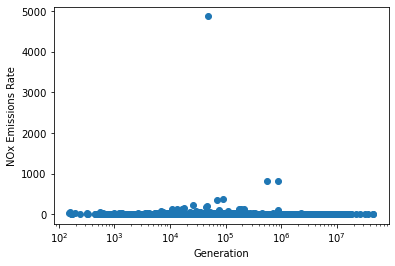

In [224]:
plt.plot(gmodel_egrid_ds['annual_modelgeneration'].sel(model_name = 'nonuc_nocoal_model'), gmodel_egrid_ds['PLNOXRTA'].sel(model_name = 'nonuc_nocoal_model'), 'o')
plt.xlabel('Generation')
plt.ylabel('NOx Emissions Rate')
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0,1e6)
#plt.ylim(0,1000)

In [245]:
gmodel_egrid_ds.where(gmodel_egrid_ds.PLNOXRTA > 500, drop=True).sel(model_name = 'nonuc_nocoal_model')['fueltype'].values

array(['Oil', 'Oil', 'Oil'], dtype=object)

In [189]:
gmodel_egrid_ds['PLNOXRTA'].sel(ORISCode = 6258, model_name = 'nonuc_nocoal_model').values

array(827.45475365)

In [213]:
gmodel_egrid_ds['annual_modelgeneration'].sel(ORISCode = 6258, model_name = 'nonuc_nocoal_model').values

array(861406.40189825)

In [242]:
limit_nonuc_coal_df.loc[limit_nonuc_coal_df['ORISCode'].isin([1006, 1868, 6258])]

,ORISCode,model_summer_NOx_conc,model_annual_NOx_conc,annual_modelgeneration,fueltype,model_name,regionname,Group 3 2024 NOx OS Allowance (tons),Boiler ID,State,Group 2 2018 NOx OS Beyond Allowance (tons),Group 1 2020 NOx OS Allowance (tons),NOx OS Allowance (tons),dif_summer
2053,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1A,Georgia,0.0,0.0,0.0,182618.41431
2054,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1B,Georgia,0.0,0.0,0.0,182618.41431
2055,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1C,Georgia,0.0,0.0,0.0,182618.41431
2056,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1D,Georgia,0.0,0.0,0.0,182618.41431
2057,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1E,Georgia,0.0,0.0,0.0,182618.41431
2058,6258,182618.41431,3.159102e+08,861406.401898,Oil,nonuc_nocoal_model,S_SOU,NaN,1F,Georgia,0.0,0.0,0.0,182618.41431


## Make a region mask to just look at North America

In [2]:
ds_emis = xr.open_dataset('../annual_emissions/inventory_power_plants_no-nuclear_no-coal.nc')

In [3]:
limit_df = pd.read_excel('./final_data/unit_level_allocations_and_underlying_data_for_the_csapr_for_the_2008_oz.xls', sheet_name = 'Final Allocations')
limit_df = limit_df.rename(columns = {'ORIS ID':'ORISCode'})
#https://www.epa.gov/csapr/csapr-allowance-allocations ##revised CSAPR allocations

<GeoAxesSubplot:>

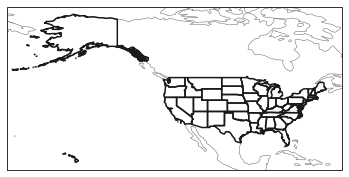

In [4]:
##### load in the regionmask for U.S. states #######
states = regionmask.defined_regions.natural_earth.us_states_50 

#plot to look at the states
states.plot(add_label=False)

In [5]:
csapr_states = states[list(set(limit_df['State'].values))[1:]]

In [7]:
ds_out = xr.open_dataset('final_data/ds_PM_O3_daily.nc4')

In [22]:
regridder = xesmf.Regridder(ds_emis, ds_out, "conservative")
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_400x900_120x160.nc 
Reuse pre-computed weights? False 
Input grid shape:           (400, 900) 
Output grid shape:          (120, 160) 
Periodic in longitude?      False

In [23]:
ds_out = regridder(ds_emis)
ds_out

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:  (lat: 120, lon: 160, time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-30T23:00:00
  * lon      (lon) float64 -140.0 -139.4 -138.8 -138.1 ... -41.88 -41.25 -40.62
  * lat      (lat) float64 10.25 10.75 11.25 11.75 ... 68.25 68.75 69.25 69.75
Data variables:
    NO       (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NO2      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SO2      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

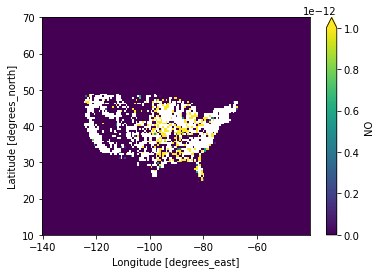

In [30]:
ds_out['NO'].mean(dim = 'time').plot(vmax = 1e-12)

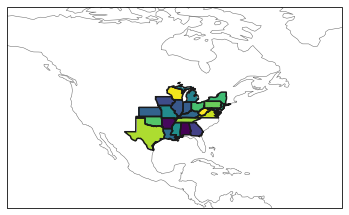

In [31]:
##### create a mask ######
mask = csapr_states.mask(ds_out, lon_name = 'lon', lat_name = 'lat')

#plot to see the mask over the states
csapr_states.plot(add_label=False)
mask.plot(add_colorbar=False)


In [35]:
#### mask our population dataset ####
US_ds = ds_out.where(~np.isnan(mask)) #create a US dataset (where the mask is not a nan value)


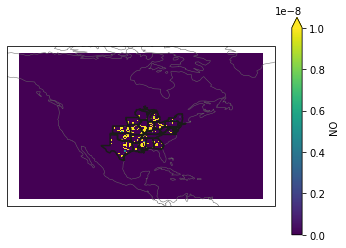

In [46]:
csapr_states.plot(add_label=False)
US_ds['NO'].sum(dim = 'time').plot(vmax = 1e-8)
